# ML LAQN Data Preparation - ALL POLLUTANTS

**Extended version:** Processes all 6 pollutants across all stations for comprehensive model training.

I will be preparing LAQN data for machine learning models in this notebook.

## What this notebook does

1. Loads cleaned data from the optimised folder.

   ```bash
   ├── optimised/                              # optimised validated measurements folder, will be use this folder's files for ML.
   │   ├── 2023_jan/                           # Monthly folders.
   │   ├── 2023_feb/
   │   ├── ...
   │   └── 2025_nov/
   │       └── {SiteCode}_{SpeciesCode}_{StartDate}_{EndDate}.csv #structure of the optimised 
   ```

2. All measurements into a single dataset.
3. Temporal features (hour, day, month).

## Output path:

data will be saved to: `data/laqn/ml_prep_all/` 

- Usual drill, I will be adding my paths under this md cell for organise myself better.

In [64]:
# starting with adding mandotary and very helpful python modules below.
import pandas as pd
import numpy as np
import os
from pathlib import Path

#save 12 section
import joblib

#visilisation section 13
import matplotlib.pyplot as plt

# preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


- The dataset/file paths will be below.

In [65]:
# ml prep file path
base_dir = Path.cwd().parent.parent / "data" / "laqn"
project_rooth = Path.cwd() / "ml_prep.ipynb"

# laqn optimised data files path
optimised_path = base_dir / "optimised"

#save 12 section paths
output_path = base_dir / "ml_prep_all"

#visualisation output path
visualisation_path = output_path / "visualisation"
visualisation_path.mkdir(parents=True, exist_ok=True)



## 1) Load LAQN data:

1. Loads cleaned data from the optimised folder.

   ```bash
   ├── optimised/                              # optimised validated measurements folder, will be use this folder's files for ML.
   │   ├── 2023_jan/                           # Monthly folders.
   │   ├── 2023_feb/
   │   ├── ...
   │   └── 2025_nov/
   │       └── {SiteCode}_{SpeciesCode}_{StartDate}_{EndDate}.csv #structure of the optimised 
   ```

   heads of the optimised files column structure: 
   `@MeasurementDateGMT,@Value,SpeciesCode,SiteCode,SpeciesName,SiteName,SiteType,Latitude,Longitude`

 - load_data function will be create to combine all the files in to one df.

   Why needs to be on one df? 

   - Each file contains hourly measurements for one station, one pollutant, one month. 
   - Time continuity : Machine learning requires identifying patterns over time. If Jan and Feb are in separate files, the model can't learn that pollution on Jan 31 affects Feb1.
   - Train/test split. %70 for training, %15 validation and %15 test.

In [66]:
def load_data(optimised_path):
    """
    Function to load the optimised data files from the laqn dataset.
    param:
        optimised_path: path for data/laqn/optimised directory.
    """
    optimised_path = Path(optimised_path)
    all_files = []
    file_count = 0

    # Get all monthly folders sorted chronologically
    monthly_folders = sorted([f for f in optimised_path.iterdir() if f.is_dir()])
    
    print(f"Found {len(monthly_folders)} monthly folders")
    
    # Iterate through each monthly folder
    for folder in monthly_folders:
        # Get all CSV files in this folder
        csv_files = list(folder.glob("*.csv"))
        
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                all_files.append(df)
                file_count += 1
            except Exception as e:
                print(f"Error reading {csv_file.name}: {e}")
        
        # Progress update
        print(f"  Loaded {folder.name}: {len(csv_files)} files")
    
    # Combine all dataframes
    if not all_files:
        raise ValueError(f"No CSV files found in {optimised_path}")
    
    combined_df = pd.concat(all_files, ignore_index=True)
    
    print(f"\n" + "="*40)
    print(f"Total files loaded: {file_count}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Columns: {list(combined_df.columns)}")
    
    return combined_df

In [67]:
# load all data
df_raw = load_data(optimised_path)

# preview data
df_raw.head(10)

Found 36 monthly folders
  Loaded 2023_apr: 141 files
  Loaded 2023_aug: 141 files
  Loaded 2023_dec: 141 files
  Loaded 2023_feb: 141 files
  Loaded 2023_jan: 141 files
  Loaded 2023_jul: 141 files
  Loaded 2023_jun: 141 files
  Loaded 2023_mar: 141 files
  Loaded 2023_may: 141 files
  Loaded 2023_nov: 138 files
  Loaded 2023_oct: 141 files
  Loaded 2023_sep: 141 files
  Loaded 2024_apr: 141 files
  Loaded 2024_aug: 141 files
  Loaded 2024_dec: 141 files
  Loaded 2024_feb: 141 files
  Loaded 2024_jan: 141 files
  Loaded 2024_jul: 141 files
  Loaded 2024_jun: 141 files
  Loaded 2024_mar: 141 files
  Loaded 2024_may: 141 files
  Loaded 2024_nov: 141 files
  Loaded 2024_oct: 141 files
  Loaded 2024_sep: 141 files
  Loaded 2025_apr: 141 files
  Loaded 2025_aug: 141 files
  Loaded 2025_feb: 141 files
  Loaded 2025_jan: 141 files
  Loaded 2025_jul: 141 files
  Loaded 2025_jun: 141 files
  Loaded 2025_mar: 141 files
  Loaded 2025_may: 141 files
  Loaded 2025_nov: 141 files
  Loaded 2025_oct:

,@MeasurementDateGMT,@Value,SpeciesCode,SiteCode,SpeciesName,SiteName,SiteType,Latitude,Longitude
0,2023-04-01 00:00:00,5.1,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
1,2023-04-01 01:00:00,4.4,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
2,2023-04-01 02:00:00,3.5,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
3,2023-04-01 03:00:00,5.3,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
4,2023-04-01 04:00:00,3.9,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
5,2023-04-01 05:00:00,4.3,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
6,2023-04-01 06:00:00,4.2,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
7,2023-04-01 07:00:00,5.5,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
8,2023-04-01 08:00:00,8.0,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606
9,2023-04-01 09:00:00,9.4,PM10,GB6,PM10 Particulate,Greenwich - Falconwood,Roadside,51.4563,0.085606


  Found 36 monthly folders
    Loaded 2023_apr: 141 files
    Loaded 2023_aug: 141 files
    Loaded 2023_dec: 141 files
    Loaded 2023_feb: 141 files
    Loaded 2023_jan: 141 files
    Loaded 2023_jul: 141 files
    Loaded 2023_jun: 141 files
    Loaded 2023_mar: 141 files
    Loaded 2023_may: 141 files
    Loaded 2023_nov: 138 files
    Loaded 2023_oct: 141 files
    Loaded 2023_sep: 141 files
    Loaded 2024_apr: 141 files
    Loaded 2024_aug: 141 files
    Loaded 2024_dec: 141 files
    Loaded 2024_feb: 141 files
    Loaded 2024_jan: 141 files
    Loaded 2024_jul: 141 files
    Loaded 2024_jun: 141 files
    Loaded 2024_mar: 141 files
    Loaded 2024_may: 141 files
    Loaded 2024_nov: 141 files
    Loaded 2024_oct: 141 files
    Loaded 2024_sep: 141 files
    Loaded 2025_apr: 141 files
    Loaded 2025_aug: 141 files
    Loaded 2025_feb: 141 files
    Loaded 2025_jan: 141 files
    Loaded 2025_jul: 141 files
    Loaded 2025_jun: 141 files
    Loaded 2025_mar: 141 files
    Loaded 2025_may: 141 files
    Loaded 2025_nov: 141 files
    Loaded 2025_oct: 141 files
    Loaded 2025_sep: 141 files
    Loaded report: 0 files

  ========================================
  Total files loaded: 4932
  Total rows: 3,446,208
  Columns: ['@MeasurementDateGMT', '@Value', 'SpeciesCode', 'SiteCode', 'SpeciesName', 'SiteName', 'SiteType', 'Latitude', 'Longitude']

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>@MeasurementDateGMT</th>
      <th>@Value</th>
      <th>SpeciesCode</th>
      <th>SiteCode</th>
      <th>SpeciesName</th>
      <th>SiteName</th>
      <th>SiteType</th>
      <th>Latitude</th>
      <th>Longitude</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2023-04-01 00:00:00</td>
      <td>5.1</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2023-04-01 01:00:00</td>
      <td>4.4</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2023-04-01 02:00:00</td>
      <td>3.5</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2023-04-01 03:00:00</td>
      <td>5.3</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>4</th>
      <td>2023-04-01 04:00:00</td>
      <td>3.9</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>5</th>
      <td>2023-04-01 05:00:00</td>
      <td>4.3</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>6</th>
      <td>2023-04-01 06:00:00</td>
      <td>4.2</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>7</th>
      <td>2023-04-01 07:00:00</td>
      <td>5.5</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>8</th>
      <td>2023-04-01 08:00:00</td>
      <td>8.0</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
    <tr>
      <th>9</th>
      <td>2023-04-01 09:00:00</td>
      <td>9.4</td>
      <td>PM10</td>
      <td>GB6</td>
      <td>PM10 Particulate</td>
      <td>Greenwich - Falconwood</td>
      <td>Roadside</td>
      <td>51.4563</td>
      <td>0.085606</td>
    </tr>
  </tbody>
</table>
</div>

In [69]:
# Check data info
print("Data shape:", df_raw.shape)
print("\nColumn types:")
print(df_raw.dtypes)
print("\nMissing values:")
print(df_raw.isnull().sum())

Data shape: (3446208, 9)

Column types:
@MeasurementDateGMT     object
@Value                 float64
SpeciesCode             object
SiteCode                object
SpeciesName             object
SiteName                object
SiteType                object
Latitude               float64
Longitude              float64
dtype: object

Missing values:
@MeasurementDateGMT         0
@Value                 464791
SpeciesCode                 0
SiteCode                    0
SpeciesName                 0
SiteName                    0
SiteType                    0
Latitude                    0
Longitude                   0
dtype: int64


    Data shape: (3446208, 9)

    Column types:
    @MeasurementDateGMT     object
    @Value                 float64
    SpeciesCode             object
    SiteCode                object
    SpeciesName             object
    SiteName                object
    SiteType                object
    Latitude               float64
    Longitude              float64
    dtype: object

    Missing values:
    @MeasurementDateGMT         0
    @Value                 464791
    SpeciesCode                 0
    SiteCode                    0
    SpeciesName                 0
    SiteName                    0
    SiteType                    0
    Latitude                    0
    Longitude                   0
    dtype: int64

## 2) Data explarotion:
Already checked data many times but  I think it is beneficial to add it here again:

- How many unique sites? - 64
- Which pollutants (species)? 6 pollutant
- Date range? 1.01.2023 till 19.11.2025

In [70]:
# Define colm names based on optimised data structure
date_col = '@MeasurementDateGMT'
value_col = '@Value'
site_col = 'SiteCode'
species_col = 'SpeciesCode'

# Convert datetime
df_raw[date_col] = pd.to_datetime(df_raw[date_col])

# run them.
print(f"Unique sites: {df_raw[site_col].nunique()}")
print(f"Unique species: {df_raw[species_col].nunique()}")
print(f"\nDate range: {df_raw[date_col].min()} to {df_raw[date_col].max()}")
print(f"\nSpecies in data:")
print(df_raw[species_col].value_counts())

Unique sites: 64
Unique species: 6

Date range: 2023-01-01 00:00:00 to 2025-11-18 23:00:00

Species in data:
SpeciesCode
NO2      1417752
PM10     1026456
PM2.5     586944
O3        268320
SO2        97824
CO         48912
Name: count, dtype: int64


    Unique sites: 64
    Unique species: 6

    Date range: 2023-01-01 00:00:00 to 2025-11-18 23:00:00

    Species in data:
    SpeciesCode
    NO2      1417752
    PM10     1026456
    PM2.5     586944
    O3        268320
    SO2        97824
    CO         48912
    Name: count, dtype: int64

## 3) Selecting target pollutants:
As I mentioned at `/docs/LAQN_DEFRA_benchmark.md` and `/docs/LAQN_data_quality.md` highest coverage:
- NO2 : 60 sites
- PM25 : 53 sites
- PM10: 43 sites
- O3: 11 sites




In [79]:
# target pollutants
target_pollutants = ['NO2', 'PM2.5', 'PM10', 'O3', 'SO2', 'CO']

# Filter data
df_filtered = df_raw[df_raw[species_col].isin(target_pollutants)].copy()

print(f"Rows before filtering: {len(df_raw):,}")
print(f"Rows after filtering: {len(df_filtered):,}")
print(f"\nPollutants included:")
print(df_filtered[species_col].value_counts())

# Fix PM2.5 in the filtered data BEFORE wide format
df_filtered['SpeciesCode'] = df_filtered['SpeciesCode'].str.replace('.', '', regex=False)

# Verify
print(df_filtered['SpeciesCode'].unique())
# Should show: ['PM10' 'NO2' 'PM25' 'SO2' 'CO' 'O3']

Rows before filtering: 3,446,208
Rows after filtering: 3,446,208

Pollutants included:
SpeciesCode
NO2      1417752
PM10     1026456
PM2.5     586944
O3        268320
SO2        97824
CO         48912
Name: count, dtype: int64
['PM10' 'NO2' 'PM25' 'SO2' 'CO' 'O3']


    Rows before filtering: 3,446,208
    Rows after filtering: 3,446,208

    Pollutants included:
    SpeciesCode
    NO2      1417752
    PM10     1026456
    PM2.5     586944
    O3        268320
    SO2        97824
    CO         48912
    Name: count, dtype: int64

## 4) Wide formatting

For ml (Air quality prediction using CNN+LSTM-based hybrid deep learning architecture', *Environmental Science and Pollution Research*, 29(8), pp. 11920-11938)

And according to their search here are the findings:
 | Method      | Input                                    | Output           |
| ----------- | ---------------------------------------- | ---------------- |
| UNI/UNI     | Historical info of target pollutant only | Single pollutant |
| MULTI/UNI   | Historical info of all pollutants        | Single pollutant |
| MULTI/MULTI | Historical info of all pollutants        | All pollutants   |

page 11922 (Results section):

> "The multivariate model without using meteorological data revealed the best results."

So order to create multivariate input I will be formatting pivot to wider,adding each station/species combination to table.




In [80]:
def wide_format(df, datetime_col, site_col, species_col, value_col):
    """
    Pivot data from long to wide format. 
    Each site-species combination becomes a column.
    Each row represents one timestamp.
    
    Params:
        datetime_col, site_col, species_col, value_col 
    """
    df = df.copy()
    
    # Create site_species identifier
    df['site_species'] = df[site_col] + '_' + df[species_col]
    
    # Pivot table
    # If duplicate datetime-site_species combinations exist, take mean
    pivoted = df.pivot_table(
        index=datetime_col,
        columns='site_species',
        values=value_col,
        aggfunc='mean'
    )
    
    # Sort by datetime
    pivoted = pivoted.sort_index()
    
    print(f"Created wide format:")
    print(f"Timestamps: {len(pivoted):,}")
    print(f"Features (site-species): {len(pivoted.columns)}")
    print(f"Date range: {pivoted.index.min()} to {pivoted.index.max()}")
    
    return pivoted

In [81]:
df_wide = wide_format(df_filtered, date_col, site_col, species_col, value_col)
print("\nFirst 10 columns:")
print(list(df_wide.columns)[:10])
df_wide.head()

Created wide format:
Timestamps: 24,456
Features (site-species): 141
Date range: 2023-01-01 00:00:00 to 2025-11-18 23:00:00

First 10 columns:
['BG1_NO2', 'BG1_SO2', 'BG2_NO2', 'BG2_PM10', 'BQ7_NO2', 'BQ7_O3', 'BQ7_PM10', 'BQ7_PM25', 'BQ9_PM10', 'BQ9_PM25']


site_species,BG1_NO2,BG1_SO2,BG2_NO2,BG2_PM10,BQ7_NO2,BQ7_O3,BQ7_PM10,BQ7_PM25,BQ9_PM10,BQ9_PM25,...,WAA_NO2,WAA_PM10,WAB_NO2,WAB_PM10,WAC_PM10,WM5_NO2,WM6_NO2,WM6_PM10,WMD_NO2,WMD_PM25
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,7.6,0.9,4.6,16.5,NaN,74.2,10.2,7.0,8.1,5.3,...,9.0,12.7,NaN,24.0,19.9,5.7,17.9,14.0,8.8,6.0
2023-01-01 01:00:00,4.4,NaN,4.4,NaN,NaN,74.4,6.8,3.9,7.1,4.2,...,7.0,6.9,NaN,7.0,8.5,6.2,15.1,17.0,9.1,6.0
2023-01-01 02:00:00,4.2,NaN,4.1,5.7,NaN,76.7,9.3,4.8,9.7,5.3,...,6.0,11.0,NaN,13.0,12.1,9.1,16.0,16.0,8.4,4.0
2023-01-01 03:00:00,4.5,0.6,3.7,10.2,NaN,76.4,11.8,6.0,13.1,6.6,...,5.0,12.5,NaN,16.0,14.7,6.2,19.7,24.0,3.2,5.0
2023-01-01 04:00:00,2.7,0.8,2.9,13.8,NaN,77.1,12.7,6.6,14.5,7.5,...,5.0,15.6,NaN,19.0,18.4,5.3,16.5,20.0,4.0,6.0


    Created wide format:
    Timestamps: 24,456
    Features (site-species): 141
    Date range: 2023-01-01 00:00:00 to 2025-11-18 23:00:00

    First 10 columns:
    ['BG1_NO2', 'BG1_SO2', 'BG2_NO2', 'BG2_PM10', 'BQ7_NO2', 'BQ7_O3', 'BQ7_PM10', 'BQ7_PM2.5', 'BQ9_PM10', 'BQ9_PM2.5']

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>site_species</th>
      <th>BG1_NO2</th>
      <th>BG1_SO2</th>
      <th>BG2_NO2</th>
      <th>BG2_PM10</th>
      <th>BQ7_NO2</th>
      <th>BQ7_O3</th>
      <th>BQ7_PM10</th>
      <th>BQ7_PM2.5</th>
      <th>BQ9_PM10</th>
      <th>BQ9_PM2.5</th>
      <th>...</th>
      <th>WAA_NO2</th>
      <th>WAA_PM10</th>
      <th>WAB_NO2</th>
      <th>WAB_PM10</th>
      <th>WAC_PM10</th>
      <th>WM5_NO2</th>
      <th>WM6_NO2</th>
      <th>WM6_PM10</th>
      <th>WMD_NO2</th>
      <th>WMD_PM2.5</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-01-01 00:00:00</th>
      <td>7.6</td>
      <td>0.9</td>
      <td>4.6</td>
      <td>16.5</td>
      <td>NaN</td>
      <td>74.2</td>
      <td>10.2</td>
      <td>7.0</td>
      <td>8.1</td>
      <td>5.3</td>
      <td>...</td>
      <td>9.0</td>
      <td>12.7</td>
      <td>NaN</td>
      <td>24.0</td>
      <td>19.9</td>
      <td>5.7</td>
      <td>17.9</td>
      <td>14.0</td>
      <td>8.8</td>
      <td>6.0</td>
    </tr>
    <tr>
      <th>2023-01-01 01:00:00</th>
      <td>4.4</td>
      <td>NaN</td>
      <td>4.4</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>74.4</td>
      <td>6.8</td>
      <td>3.9</td>
      <td>7.1</td>
      <td>4.2</td>
      <td>...</td>
      <td>7.0</td>
      <td>6.9</td>
      <td>NaN</td>
      <td>7.0</td>
      <td>8.5</td>
      <td>6.2</td>
      <td>15.1</td>
      <td>17.0</td>
      <td>9.1</td>
      <td>6.0</td>
    </tr>
    <tr>
      <th>2023-01-01 02:00:00</th>
      <td>4.2</td>
      <td>NaN</td>
      <td>4.1</td>
      <td>5.7</td>
      <td>NaN</td>
      <td>76.7</td>
      <td>9.3</td>
      <td>4.8</td>
      <td>9.7</td>
      <td>5.3</td>
      <td>...</td>
      <td>6.0</td>
      <td>11.0</td>
      <td>NaN</td>
      <td>13.0</td>
      <td>12.1</td>
      <td>9.1</td>
      <td>16.0</td>
      <td>16.0</td>
      <td>8.4</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>2023-01-01 03:00:00</th>
      <td>4.5</td>
      <td>0.6</td>
      <td>3.7</td>
      <td>10.2</td>
      <td>NaN</td>
      <td>76.4</td>
      <td>11.8</td>
      <td>6.0</td>
      <td>13.1</td>
      <td>6.6</td>
      <td>...</td>
      <td>5.0</td>
      <td>12.5</td>
      <td>NaN</td>
      <td>16.0</td>
      <td>14.7</td>
      <td>6.2</td>
      <td>19.7</td>
      <td>24.0</td>
      <td>3.2</td>
      <td>5.0</td>
    </tr>
    <tr>
      <th>2023-01-01 04:00:00</th>
      <td>2.7</td>
      <td>0.8</td>
      <td>2.9</td>
      <td>13.8</td>
      <td>NaN</td>
      <td>77.1</td>
      <td>12.7</td>
      <td>6.6</td>
      <td>14.5</td>
      <td>7.5</td>
      <td>...</td>
      <td>5.0</td>
      <td>15.6</td>
      <td>NaN</td>
      <td>19.0</td>
      <td>18.4</td>
      <td>5.3</td>
      <td>16.5</td>
      <td>20.0</td>
      <td>4.0</td>
      <td>6.0</td>
    </tr>
  </tbody>
</table>
<p>5 rows × 141 columns</p>
</div>

In [82]:
# Check column names after wide_format
print("Sample columns after wide_format:")
print([c for c in df_wide.columns if 'PM2' in c][:5])

Sample columns after wide_format:
['BQ7_PM25', 'BQ9_PM25', 'BT4_PM25', 'BT5_PM25', 'BT6_PM25']


## 5) Handle Missing Values - Maximum Data Retention

### Strategy: Tiered Imputation

| Step | Method | Gap Size | Rationale |
|------|--------|----------|----------|
| 1 | Drop poor columns | >70% missing | Too unreliable |
| 2 | Linear interpolation | up to 6 hours | Air quality is autocorrelated |
| 3 | Forward/backward fill | up to 4 hours | Edge cases |
| 4 | Rolling 24h median | remaining | Preserves daily patterns |
| 5 | Column median | final gaps | Last resort |

In [83]:
missing_pct = (df_wide.isnull().sum() / len(df_wide) * 100).sort_values(ascending=False)
print("Missing value percentage by column (top 20):")
print(missing_pct.head(20))
print(f"\nTotal cells: {df_wide.size:,}")
print(f"Missing cells: {df_wide.isnull().sum().sum():,}")
print(f"Missing percentage: {df_wide.isnull().sum().sum() / df_wide.size * 100:.2f}%")

Missing value percentage by column (top 20):
site_species
WM6_PM10    62.798495
CE3_NO2     46.589794
TL4_NO2     40.407262
RI2_O3      39.818449
BG1_SO2     38.260550
BX1_SO2     37.998855
WA7_NO2     37.765783
TH4_PM25    33.169774
CD1_PM10    31.534184
WAA_NO2     31.505561
CE3_PM25    31.288845
CE3_PM10    31.288845
GN6_PM25    30.990350
CR8_PM25    30.650965
TH4_PM10    30.528296
CD1_PM25    30.021263
GN0_PM25    29.420183
BT5_PM25    29.048086
HG4_O3      28.999019
CD1_NO2     28.557409
dtype: float64

Total cells: 3,448,296
Missing cells: 466,879
Missing percentage: 13.54%


    Missing value percentage by column (top 20):
    site_species
    WM6_PM10    62.798495
    CE3_NO2     46.589794
    TL4_NO2     40.407262
    RI2_O3      39.818449
    BG1_SO2     38.260550
    BX1_SO2     37.998855
    WA7_NO2     37.765783
    TH4_PM25    33.169774
    CD1_PM10    31.534184
    WAA_NO2     31.505561
    CE3_PM25    31.288845
    CE3_PM10    31.288845
    GN6_PM25    30.990350
    CR8_PM25    30.650965
    TH4_PM10    30.528296
    CD1_PM25    30.021263
    GN0_PM25    29.420183
    BT5_PM25    29.048086
    HG4_O3      28.999019
    CD1_NO2     28.557409
    dtype: float64

    Total cells: 3,448,296
    Missing cells: 466,879
    Missing percentage: 13.54%

In [85]:
pm25_cols = [c for c in df_wide.columns if 'PM25' in c]
print(f"PM2.5 columns in wide format: {len(pm25_cols)}")
print("\nPM2.5 columns missing rates:")
for col in pm25_cols:
    missing = df_wide[col].isnull().sum() / len(df_wide) * 100
    print(f"  {col}: {missing:.1f}% missing")

PM2.5 columns in wide format: 24

PM2.5 columns missing rates:
  BQ7_PM25: 11.7% missing
  BQ9_PM25: 6.1% missing
  BT4_PM25: 1.1% missing
  BT5_PM25: 29.0% missing
  BT6_PM25: 27.6% missing
  BT8_PM25: 23.3% missing
  BX2_PM25: 2.3% missing
  BY7_PM25: 8.3% missing
  CD1_PM25: 30.0% missing
  CE2_PM25: 9.0% missing
  CE3_PM25: 31.3% missing
  CR8_PM25: 30.7% missing
  CW3_PM25: 13.4% missing
  GB0_PM25: 28.1% missing
  GN0_PM25: 29.4% missing
  GN3_PM25: 9.4% missing
  GN6_PM25: 31.0% missing
  GR9_PM25: 8.6% missing
  HP1_PM25: 0.5% missing
  KC1_PM25: 22.2% missing
  LB4_PM25: 18.6% missing
  TH4_PM25: 33.2% missing
  TL6_PM25: 19.4% missing
  WMD_PM25: 2.5% missing


### Step 1: Drop columns with more than 70% missing

In [86]:
MAX_MISSING = 70
cols_before = len(df_wide.columns)
missing_rates = df_wide.isnull().sum() / len(df_wide) * 100
cols_to_keep = missing_rates[missing_rates <= MAX_MISSING].index.tolist()
cols_dropped = cols_before - len(cols_to_keep)

df_step1 = df_wide[cols_to_keep].copy()

print(f"Step 1: Column filtering (>{MAX_MISSING}% missing)")
print(f"="*50)
print(f"Columns before: {cols_before}")
print(f"Columns after: {len(cols_to_keep)}")
print(f"Columns dropped: {cols_dropped}")
print(f"\nPM2.5 columns remaining: {sum(1 for c in cols_to_keep if 'PM25' in c)}")

Step 1: Column filtering (>70% missing)
Columns before: 141
Columns after: 141
Columns dropped: 0

PM2.5 columns remaining: 24


    Step 1: Column filtering (>70% missing)
    ==================================================
    Columns before: 141
    Columns after: 141
    Columns dropped: 0

    PM2.5 columns remaining: 24

### Step 2: Linear interpolation for gaps up to 6 hours

In [95]:
INTERP_LIMIT = 6
missing_before = df_step1.isnull().sum().sum()

df_step2 = df_step1.interpolate(method='linear', limit=INTERP_LIMIT, limit_direction='both')

missing_after = df_step2.isnull().sum().sum()
filled_by_interp = missing_before - missing_after

print(f"Step 2: Linear interpolation (limit={INTERP_LIMIT} hours)")
print(f"="*40)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled: {filled_by_interp:,} ({filled_by_interp/missing_before*100:.1f}%)")

Step 2: Linear interpolation (limit=6 hours)
Missing before: 466,879
Missing after: 406,015
Filled: 60,864 (13.0%)


    Step 2: Linear interpolation (limit=6 hours)
    ========================================
    Missing before: 466,879
    Missing after: 406,015
    Filled: 60,864 (13.0%)

### Step 3: Forward/backward fill up to 4 hours

Some gaps remain at dataset boundaries where interpolation cannot work (no value on one side). Forward fill (ffill) and backward fill (bfill) handle these edge cases:
- Start of data: [NaN, NaN, 10, 12]  → bfill → [10, 10, 10, 12]
- End of data:   [10, 12, NaN, NaN]  → ffill → [10, 12, 12, 12]
**Limit of 6 **: Fills edge gaps while avoiding unrealistic long constant values.

In [96]:
# Step 3: Forward/backward fill remaining small gaps
FILL_LIMIT = 4  # max consecutive NaN to ffill/bfill

missing_before = df_step2.isnull().sum().sum()

# Forward fill first, then backward fill for remaining
df_step3 = df_step2.ffill(limit=FILL_LIMIT).bfill(limit=FILL_LIMIT)

missing_after = df_step3.isnull().sum().sum()
filled_by_ffill = missing_before - missing_after

print(f"Step 3: Forward/backward fill (limit={FILL_LIMIT})")
print(f"="*50)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled by ffill/bfill: {filled_by_ffill:,}")

Step 3: Forward/backward fill (limit=4)
Missing before: 406,015
Missing after: 394,115
Filled by ffill/bfill: 11,900


    Step 3: Forward/backward fill (limit=4)
    ==================================================
    Missing before: 406,015
    Missing after: 394,115
    Filled by ffill/bfill: 11,900

### Step 4: Rolling 24-hour median fill

For remaining gaps (large equipment outages), use the median of surrounding 24 hours. This captures local time patterns:

Hour 8:  [NaN]  → median of hours 6,7,9,10 → local morning value
Hour 20: [NaN]  → median of hours 18,19,21,22 → local evening value



- i wanna use the most part of the dataset so I will be trying to rolling 24 hour median.

In [98]:
WINDOW_SIZE = 336 # 7 week instead of day
missing_before = df_step3.isnull().sum().sum()

rolling_median = df_step3.rolling(window=WINDOW_SIZE, center=True, min_periods=1).median()
df_step4 = df_step3.fillna(rolling_median)

missing_after = df_step4.isnull().sum().sum()
print(f"Step 4: Rolling {WINDOW_SIZE} hour median")
print(f"="*50)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")
print(f"Filled: {missing_before - missing_after:,}")

Step 4: Rolling 336 hour median
Missing before: 394,115
Missing after: 252,598
Filled: 141,517


    Step 4: Rolling 336 hour median
    ==================================================
    Missing before: 394,115
    Missing after: 252,598
    Filled: 141,517

### Step 5: Column median for final cleanup

In [99]:
missing_before = df_step4.isnull().sum().sum()
df_clean = df_step4.fillna(df_step4.median())
missing_after = df_clean.isnull().sum().sum()

print(f"Step 5: Column median fill")
print(f"="*40)
print(f"Missing before: {missing_before:,}")
print(f"Missing after: {missing_after:,}")

assert df_clean.isnull().sum().sum() == 0
print(f"\nAll {len(df_clean):,} rows retained (100%)")

Step 5: Column median fill
Missing before: 252,598
Missing after: 0

All 24,456 rows retained (100%)


    Step 5: Column median fill
    ========================================
    Missing before: 252,598
    Missing after: 0

    All 24,456 rows retained (100%)

Step 5 filled 369,538 values (79% of all missing!) with column median. That's a lot of "flat" values that don't reflect temporal patterns.

### Missing Value Handling Summary

In [101]:
# Summary of missing value handling
print("="*40)
print("NaN Handling Summary")
print("="*40)

print(f"\nColumn filtering (>{MAX_MISSING}% missing):")
print(f"  Before: {cols_before} columns")
print(f"  After: {len(cols_to_keep)} columns")
print(f"  Dropped: {cols_dropped} columns")

print(f"\nRow retention:")
print(f"  Original timestamps: {len(df_wide):,}")
print(f"  Final rows: {len(df_clean):,}")
print(f"  Retention rate: {len(df_clean)/len(df_wide)*100:.1f}%")

print(f"\nFinal dataset:")
print(f"  Shape: {df_clean.shape}")
print(f"  Missing values: {df_clean.isnull().sum().sum()}")

# Pollutant breakdown in final columns
# Correct pollutant breakdown
print(f"\nPollutants in final dataset:")

final_cols = df_clean.columns.tolist()
no2 = sum(1 for c in final_cols if '_NO2' in c)
pm25 = sum(1 for c in final_cols if '_PM25' in c)
pm10 = sum(1 for c in final_cols if '_PM10' in c)
o3 = sum(1 for c in final_cols if '_O3' in c)
so2 = sum(1 for c in final_cols if '_SO2' in c)
co = sum(1 for c in final_cols if '_CO' in c)

print(f"\nPollutants:")
print(f"  NO2: {no2}, PM2.5: {pm25}, PM10: {pm10}, O3: {o3}, SO2: {so2}, CO: {co}")
print(f"  Total: {no2+pm25+pm10+o3+so2+co}")

NaN Handling Summary

Column filtering (>70% missing):
  Before: 141 columns
  After: 141 columns
  Dropped: 0 columns

Row retention:
  Original timestamps: 24,456
  Final rows: 24,456
  Retention rate: 100.0%

Final dataset:
  Shape: (24456, 141)
  Missing values: 0

Pollutants in final dataset:

Pollutants:
  NO2: 58, PM2.5: 24, PM10: 42, O3: 11, SO2: 4, CO: 2
  Total: 141


    ========================================
    NaN Handling Summary
    ========================================

    Column filtering (>70% missing):
    Before: 141 columns
    After: 141 columns
    Dropped: 0 columns

    Row retention:
    Original timestamps: 24,456
    Final rows: 24,456
    Retention rate: 100.0%

    Final dataset:
    Shape: (24456, 141)
    Missing values: 0

    Pollutants in final dataset:

    Pollutants:
    NO2: 58, PM2.5: 24, PM10: 42, O3: 11, SO2: 4, CO: 2
    Total: 141

## Summary: Missing Value Handling for LAQN Data

### What You Did

A tiered imputation approach to retain 100% of timestamps whilst handling missing values appropriately based on gap characteristics:

| Step | Method                     | Gap Type           | Filled          | Rationale                                       |
| ---- | -------------------------- | ------------------ | --------------- | ----------------------------------------------- |
| 1    | Column filter >70%         | Unreliable sensors | 0 dropped       | All columns had acceptable coverage             |
| 2    | Linear interpolation (6h)  | Short gaps         | 60,864 (13.0%)  | Air quality is autocorrelated, safe to estimate |
| 3    | Forward/backward fill (4h) | Edge gaps          | 11,900 (2.5%)   | Handles dataset boundaries                      |
| 4    | Rolling 2 week median      | Medium gaps        | 141,517 (30.3%) | Preserves weekly patterns                       |
| 5    | Column median              | Long outages       | 252,598 (54.1%) | Conservative fill for extended sensor failures  |

### Achievments:

**Final Dataset:**

```
Shape: (24,456 rows × 141 columns)
Missing values: 0
```

**Data Retention:**

- Timestamps: 24,456 (100% retained)
- Columns: 141 (100% retained, 0 dropped)
- Retention rate: 100.0%

**Pollutant Coverage:**

| Pollutant | Stations |
| --------- | -------- |
| NO2       | 58       |
| PM10      | 42       |
| PM2.5     | 24       |
| O3        | 11       |
| SO2       | 4        |
| CO        | 2        |
| **Total** | **141**  |

**Data Quality Breakdown:**

- Original missing: 466,879 cells (13.5% of dataset)
- Interpolated/filled with temporal context: 214,281 cells (46% of missing)
- Median filled: 252,598 cells (54% of missing, 7.3% of total dataset)
- **Real + temporally interpolated data: 92.7%**

## 6) Temporal features

Adding AFTER pivot (before would lose them).

In [102]:
df_features = df_clean.copy()
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

print(f"Added temporal features")
print(f"Total features: {len(df_features.columns)}")
df_features[['hour', 'day_of_week', 'month', 'is_weekend']].head()

Added temporal features
Total features: 145


site_species,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,
2023-01-01 00:00:00,0,6,1,1
2023-01-01 01:00:00,1,6,1,1
2023-01-01 02:00:00,2,6,1,1
2023-01-01 03:00:00,3,6,1,1
2023-01-01 04:00:00,4,6,1,1


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>site_species</th>
      <th>hour</th>
      <th>day_of_week</th>
      <th>month</th>
      <th>is_weekend</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-01-01 00:00:00</th>
      <td>0</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 01:00:00</th>
      <td>1</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 02:00:00</th>
      <td>2</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 03:00:00</th>
      <td>3</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 04:00:00</th>
      <td>4</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

Added temporal features
Total features: 145

# 7) Train/validation/test split (temporal)

In [36]:
def temporal_wide(df):
    """
    Add temporal features to wide format data.
    """
    df = df.copy()
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    print(f"Added temporal features")
    print(f"Total features: {len(df.columns)}")
    
    return df

In [45]:
# Add temporal features
df_features = temporal_wide(df_clean)

# Preview
df_features[['hour', 'day_of_week', 'month', 'is_weekend']].head()

#  print(f"df_features: {df_features.shape}")



Added temporal features
Total features: 39


site_species,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,
2023-01-01 00:00:00,0,6,1,1
2023-01-01 01:00:00,1,6,1,1
2023-01-01 02:00:00,2,6,1,1
2023-01-01 03:00:00,3,6,1,1
2023-01-01 04:00:00,4,6,1,1


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>site_species</th>
      <th>hour</th>
      <th>day_of_week</th>
      <th>month</th>
      <th>is_weekend</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-01-01 00:00:00</th>
      <td>0</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 01:00:00</th>
      <td>1</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 02:00:00</th>
      <td>2</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 03:00:00</th>
      <td>3</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2023-01-01 04:00:00</th>
      <td>4</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>


Added temporal features
Total features: 39

## 8) Normalise the data

Different features have different scales:
- NO2: 0-200 µg/m³
- PM25: 0-100 µg/m³
- Hour: 0-23

Neural networks work best when all inputs are on the same scale (0 to 1).

MinMaxScaler from scikit-learn which applies:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

This transforms every value to a number between 0 and 1 (Géron, 2022).

**Important:** Save the scaler object to reverse the transformation later when interpreting predictions.

- MinMaxScaler is  scikit-learn lib. 
Scikit-learn (no date) sklearn.preprocessing.MinMaxScaler. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

Géron, A. (2022) Hands-on machine learning with scikit-learn, Keras, and TensorFlow. 3rd edn. Sebastopol: O'Reilly Media.
Chapter 2 


In [37]:
def normalise_data(df):
    """
    Normalise all columns to 0-1 range using scikit-learn MinMaxScaler.

    """
    feature_names = df.columns.tolist()
    index = df.index
    
    # Fit and transform
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalised_values = scaler.fit_transform(df.values)
    
    # Create dataframe
    normalised_df = pd.DataFrame(
        normalised_values,
        columns=feature_names,
        index=index
    )
    
    print(f"Data normalised to range 0, 1")
    print(f"Original range [{df.values.min():.2f}, {df.values.max():.2f}]")
    print(f"Normalised range [{normalised_values.min():.2f}, {normalised_values.max():.2f}]")
    
    return normalised_df, scaler, feature_names

In [44]:
# Normalise the data
df_normalised, scaler, feature_names = normalise_data(df_features)

# Preview
df_normalised.head()

# print(f"df_normalised: {df_normalised.shape}")


Data normalised to range 0, 1
Original range [0.00, 587.00]
Normalised range [0.00, 1.00]


,EN5_NO2,WMD_NO2,BT5_NO2,HP1_PM10,EN1_NO2,ME9_NO2,BT6_NO2,BT8_PM10,HV1_NO2,BT4_PM10,...,GN3_PM10,LB4_NO2,GN4_PM10,GN4_NO2,EA8_NO2,EA6_NO2,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.061135,0.050996,0.069828,0.075868,0.067465,0.073740,0.062230,0.095833,0.066303,0.066440,...,0.208388,0.094123,0.055256,0.017544,0.058506,0.071708,0.000000,1.0,0.0,1.0
2023-01-01 01:00:00,0.055022,0.052755,0.061207,0.064568,0.056583,0.095561,0.048401,0.033333,0.042688,0.025554,...,0.041940,0.244261,0.013477,0.023684,0.026103,0.085398,0.043478,1.0,0.0,1.0
2023-01-01 02:00:00,0.056769,0.048652,0.045690,0.078289,0.046790,0.069977,0.035436,0.045833,0.030881,0.030664,...,0.103539,0.175849,0.045148,0.019298,0.025203,0.073664,0.086957,1.0,0.0,1.0
2023-01-01 03:00:00,0.041921,0.018171,0.031897,0.103309,0.038085,0.064710,0.041487,0.054167,0.042688,0.025554,...,0.142857,0.137741,0.073450,0.012281,0.022502,0.058018,0.130435,1.0,0.0,1.0
2023-01-01 04:00:00,0.039301,0.022860,0.052586,0.120258,0.043526,0.048157,0.052723,0.062500,0.035422,0.028961,...,0.176933,0.145546,0.097709,0.007895,0.036004,0.080183,0.173913,1.0,0.0,1.0


  Data normalised to range 0, 1
  Original range [0.00, 587.00]
  Normalised range [0.00, 1.00]
  df_normalised: (14221, 39)

  <div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>EN5_NO2</th>
      <th>WMD_NO2</th>
      <th>BT5_NO2</th>
      <th>HP1_PM10</th>
      <th>EN1_NO2</th>
      <th>ME9_NO2</th>
      <th>BT6_NO2</th>
      <th>BT8_PM10</th>
      <th>HV1_NO2</th>
      <th>BT4_PM10</th>
      <th>...</th>
      <th>GN3_PM10</th>
      <th>LB4_NO2</th>
      <th>GN4_PM10</th>
      <th>GN4_NO2</th>
      <th>EA8_NO2</th>
      <th>EA6_NO2</th>
      <th>hour</th>
      <th>day_of_week</th>
      <th>month</th>
      <th>is_weekend</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-01-01 00:00:00</th>
      <td>0.061135</td>
      <td>0.050996</td>
      <td>0.069828</td>
      <td>0.075868</td>
      <td>0.067465</td>
      <td>0.073740</td>
      <td>0.062230</td>
      <td>0.095833</td>
      <td>0.066303</td>
      <td>0.066440</td>
      <td>...</td>
      <td>0.208388</td>
      <td>0.094123</td>
      <td>0.055256</td>
      <td>0.017544</td>
      <td>0.058506</td>
      <td>0.071708</td>
      <td>0.000000</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>2023-01-01 01:00:00</th>
      <td>0.055022</td>
      <td>0.052755</td>
      <td>0.061207</td>
      <td>0.064568</td>
      <td>0.056583</td>
      <td>0.095561</td>
      <td>0.048401</td>
      <td>0.033333</td>
      <td>0.042688</td>
      <td>0.025554</td>
      <td>...</td>
      <td>0.041940</td>
      <td>0.244261</td>
      <td>0.013477</td>
      <td>0.023684</td>
      <td>0.026103</td>
      <td>0.085398</td>
      <td>0.043478</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>2023-01-01 02:00:00</th>
      <td>0.056769</td>
      <td>0.048652</td>
      <td>0.045690</td>
      <td>0.078289</td>
      <td>0.046790</td>
      <td>0.069977</td>
      <td>0.035436</td>
      <td>0.045833</td>
      <td>0.030881</td>
      <td>0.030664</td>
      <td>...</td>
      <td>0.103539</td>
      <td>0.175849</td>
      <td>0.045148</td>
      <td>0.019298</td>
      <td>0.025203</td>
      <td>0.073664</td>
      <td>0.086957</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>2023-01-01 03:00:00</th>
      <td>0.041921</td>
      <td>0.018171</td>
      <td>0.031897</td>
      <td>0.103309</td>
      <td>0.038085</td>
      <td>0.064710</td>
      <td>0.041487</td>
      <td>0.054167</td>
      <td>0.042688</td>
      <td>0.025554</td>
      <td>...</td>
      <td>0.142857</td>
      <td>0.137741</td>
      <td>0.073450</td>
      <td>0.012281</td>
      <td>0.022502</td>
      <td>0.058018</td>
      <td>0.130435</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>2023-01-01 04:00:00</th>
      <td>0.039301</td>
      <td>0.022860</td>
      <td>0.052586</td>
      <td>0.120258</td>
      <td>0.043526</td>
      <td>0.048157</td>
      <td>0.052723</td>
      <td>0.062500</td>
      <td>0.035422</td>
      <td>0.028961</td>
      <td>...</td>
      <td>0.176933</td>
      <td>0.145546</td>
      <td>0.097709</td>
      <td>0.007895</td>
      <td>0.036004</td>
      <td>0.080183</td>
      <td>0.173913</td>
      <td>1.0</td>
      <td>0.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>
<p>5 rows × 39 columns</p>
</div>

## 9) Create sequences

### Why sequences are needed

A single row of data is just one moment with no context. Machine learning needs to see what happened before to make predictions.

By creating sequences, I give the model historical context. Instead of seeing one timestamp, it sees the last 12 hours of measurements and can learn patterns like pollution rising or falling.

### What is the sliding window method?

The sliding window method restructures time series data for supervised learning (Brownlee, J. (2017) ). With `n_past=12`, I use the last 12 hours to predict the next hour:
```
Input (X):  [hour1, hour2, hour3, ..., hour12]  → shape: (12, num_features)
Output (y): [hour13]                            → shape: (num_features,)
```

The window slides forward to create many training samples:
```
Sample 1: hours 1-12  → predict hour 13
Sample 2: hours 2-13  → predict hour 14
Sample 3: hours 3-14  → predict hour 15
...
```

### Why 12 hours?

Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021). tested frame sizes between 8 and 15 hours for air quality prediction. I chose 12 because it captures half a day of patterns including rush hour variations.

https://www.inf.szte.hu/~korosig/teach/books/Jason%20Brownlee%20-%20Introduction%20to%20Time%20Series%20Forecasting%20with%20Python%20-%20How%20to%20Prepare%20Data%20and%20Develop%20Models%20to%20Predict%20the%20Future-v1.9%20(2020).pdf

In [ ]:
def create_sequences(data, n_past=12, n_future=1):
    """
    Create sequences for time series prediction using rolling window. 
    Sliding window method restructures time series as supervised learning
    problem (Brownlee, J. (2017) ). Window size based on Gilik, Ogrenci and 
    Ozmen (2021) who tested values between 8-15 hours. 
    
    Params

    data : numpy.ndarray Normalised data of shape (timestamps, features).
    n_past : int  Number of past timesteps to use as input.
    n_future : int Number of future timesteps to predict.
    
    Returns
    
    tuple: (X, y)
        X: Input sequences, shape (samples, n_past, features) (coordinates X needs to be capital)
        y: Target values, shape (samples, features)
    """
    X, y = [], []
    
    for i in range(n_past, len(data) - n_future + 1):
        #  past n_past timesteps
        X.append(data[i - n_past:i])
        # Output value at n_future steps ahead
        y.append(data[i + n_future - 1])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Created sequences:")
    print(f" n_past (history): {n_past} hours")
    print(f"n_future (predict): {n_future} hour")
    print(f"Samples: {len(X):,}")
    print(f"X shape: {X.shape} (samples, timesteps, features)")
    print(f"y shape: {y.shape} (samples, features)")
    
    return X, y

In [47]:
# Configuration
N_PAST = 12      # Use last 12 hours as input
N_FUTURE = 1     # Predict 1 hour ahead

# Convert to numpy array
data_array = df_normalised.values

# Create sequences
X, y = create_sequences(data_array, n_past=N_PAST, n_future=N_FUTURE)

Created sequences:
 n_past (history): 12 hours
n_future (predict): 1 hour
Samples: 14,209
X shape: (14209, 12, 39) (samples, timesteps, features)
y shape: (14209, 39) (samples, features)


    Created sequences:
    n_past (history): 12 hours
    n_future (predict): 1 hour
    Samples: 46
    X shape: (46, 12, 90) (samples, timesteps, features)
    y shape: (46, 90) (samples, features)

In [48]:
# Check how many rows at each step
print(f"After pivot (wide format): {len(df_wide)}")
print(f"After handle_missing_values: {len(df_clean)}")
print(f"After normalisation: {len(df_normalised)}")

After pivot (wide format): 24456
After handle_missing_values: 14221
After normalisation: 14221


## 10) Split into train/validation/test

### Why split the data?

Split data into three parts:
- Training (70%): model learns patterns from this
- Validation (15%): tune model and check for overfitting during training
- Test (15%): final evaluation, model never sees this until the end
```
|-------- Training (70%) --------|--- Val (15%) ---|--- Test (15%) ---|
Aug 2023                                                        Nov 2025
```

### Why sequential split, not random?

For time series, split sequentially (oldest to newest), not randomly. 
Random splitting causes data leakage where model sees future data when 
training to predict the past (Brownlee, J. (2017) ).

### Why 70/15/15 ratio?

Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021). used this split for air quality prediction.

In [ ]:
def split_time_series(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split time series data sequentially into train/validation and test
    Sequential split avoids data leakage (Brownlee, J. (2017) ).
    Ratio based on Gilik, Ogrenci and Ozmen (2021)
    """
    n_samples = len(X)
    
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))
    
    splits = {
        'X_train': X[:train_end],
        'y_train': y[:train_end],
        'X_val': X[train_end:val_end],
        'y_val': y[train_end:val_end],
        'X_test': X[val_end:],
        'y_test': y[val_end:]
    }
    
    print(f"Data split (sequential):")
    print(f"Training: {len(splits['X_train']):,} samples ({train_ratio*100:.0f}%)")
    print(f"Validation: {len(splits['X_val']):,} samples ({val_ratio*100:.0f}%)")
    print(f"Test: {len(splits['X_test']):,} samples ({test_ratio*100:.0f}%)")
    
    return splits

In [50]:
# Split the data
splits = split_time_series(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

Data split (sequential):
Training: 9,946 samples (70%)
Validation: 2,131 samples (15%)
Test: 2,132 samples (15%)


    Data split (sequential):
    Training: 9,946 samples (70%)
    Validation: 2,131 samples (15%)
    Test: 2,132 samples (15%)

## 11) Prepare data for random forest (RF)

### flatten the data: 2d input and squences: 3d

Random forest expects 2D input: (samples, features)

The equences are 3D: (samples, timesteps, features)

CNN can process 3D sequences directly, but RF needs a flat table.
So I reshape the data by flattening timesteps and features into one dimension (Géron, A. (2023), Ch. 7).

```
Before: (9946, 12, 39)  → 9946 samples, 12 timesteps, 39 features
After:  (9946, 468)     → 9946 samples, 12 × 39 = 468 features
```

Each flattened row contains all 12 hours of history for all 39 features.

### Why create feature names?

Random forest can show feature importance, which tells us which inputs matter most for prediction. Need meaningful names to interpret results, so I create names like
`EN5_NO2_t-12` (NO2 at station EN5, 12 hours ago).

In [ ]:
def flatten_rf(X):
    """
    Flatten 3D sequences to 2D for random forest.
    RF needs 2D input, CNN handles 3D (Géron, 2022, Ch. 7).
    
    Shape: (samples, timesteps, features) (samples, timesteps * features
    """
    n_samples = X.shape[0]
    return X.reshape(n_samples, -1)

In [52]:
# Flatten for RF
X_train_rf = flatten_rf(splits['X_train'])
X_val_rf = flatten_rf(splits['X_val'])
X_test_rf = flatten_rf(splits['X_test'])

print(f"Random forest input shapes:")
print(f"X_train_rf: {X_train_rf.shape}")
print(f"X_val_rf: {X_val_rf.shape}")
print(f"X_test_rf: {X_test_rf.shape}")

# Adding to splits dict
splits['X_train_rf'] = X_train_rf
splits['X_val_rf'] = X_val_rf
splits['X_test_rf'] = X_test_rf

Random forest input shapes:
X_train_rf: (9946, 468)
X_val_rf: (2131, 468)
X_test_rf: (2132, 468)


    Random forest input shapes:
    X_train_rf: (9946, 468)
    X_val_rf: (2131, 468)
    X_test_rf: (2132, 468)

In [ ]:
N_PAST = 12  # lookback steps

# Creating predicted names for RD 
rf_feature_names = []
for t in range(N_PAST):
    for feat in feature_names:
        rf_feature_names.append(f"{feat}_t-{N_PAST - t}")

print(f"Created {len(rf_feature_names)} feature names for random forest")
print(f"\nFirst 5: {rf_feature_names[:5]}")
print(f"Last 5: {rf_feature_names[-5:]}")

Created 468 feature names for random forest

First 5: ['EN5_NO2_t-12', 'WMD_NO2_t-12', 'BT5_NO2_t-12', 'HP1_PM10_t-12', 'EN1_NO2_t-12']
Last 5: ['EA6_NO2_t-1', 'hour_t-1', 'day_of_week_t-1', 'month_t-1', 'is_weekend_t-1']


    Created 468 feature names for random forest

    First 5: ['EN5_NO2_t-12', 'WMD_NO2_t-12', 'BT5_NO2_t-12', 'HP1_PM10_t-12', 'EN1_NO2_t-12']
    Last 5: ['EA6_NO2_t-1', 'hour_t-1', 'day_of_week_t-1', 'month_t-1', 'is_weekend_t-1']

## 12) Save everything

- Save results for next.Using numpy for arrays and joblib for objects.

In [54]:
# Summary before saving
print("-"*40)
print("ML Data Preparation Summary")
print("-"*40)
print(f"\nOriginal rows: {len(df_raw):,}")
print(f"Final timestamps: {len(df_normalised):,}")
print(f"Features: {len(feature_names)}")
print(f"Sequences: {len(X):,}")
print(f"\nSequence parameters:")
print(f"n_past: {N_PAST} hours")
print(f"n_future: {N_FUTURE} hour")
print(f"\nsplits:")
print(f"Train: {len(splits['X_train']):,}")
print(f"validation: {len(splits['X_val']):,}")
print(f"Test: {len(splits['X_test']):,}")
print(f"\nShapes:")
print(f"CNN: {splits['X_train'].shape}")
print(f"RF: {splits['X_train_rf'].shape}")

----------------------------------------
ML Data Preparation Summary
----------------------------------------

Original rows: 3,446,208
Final timestamps: 14,221
Features: 39
Sequences: 14,209

Sequence parameters:
n_past: 12 hours
n_future: 1 hour

splits:
Train: 9,946
validation: 2,131
Test: 2,132

Shapes:
CNN: (9946, 12, 39)
RF: (9946, 468)


        ----------------------------------------
        ML Data Preparation Summary
        ----------------------------------------

        Original rows: 3,446,208
        Final timestamps: 14,221
        Features: 39
        Sequences: 14,209

        Sequence parameters:
        n_past: 12 hours
        n_future: 1 hour

        splits:
        Train: 9,946
        validation: 2,131
        Test: 2,132

        Shapes:
        CNN: (9946, 12, 39)
        RF: (9946, 468)

In [60]:
def ml_save(splits, scaler, feature_names, rf_feature_names, 
                 output_path, n_past, n_future, target_pollutants):
    """
    Save all processed data for model ML
    Numpy arrays for data, joblib for scaler and metadata
    """
    #data/lawqn/ml_prep folder
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # save numpy 
    for key, arr in splits.items():
        np.save(output_path / f"{key}.npy", arr)
        print(f"{key}.npy: {arr.shape}")
    
    # Save scaler for transform 
    joblib.dump(scaler, output_path / "scaler.joblib")
    print(f"scaler.joblib")
    
    # Save feature names
    joblib.dump(feature_names, output_path / "feature_names.joblib")
    joblib.dump(rf_feature_names, output_path / "rf_feature_names.joblib")
    print(f"feature_names.joblib ({len(feature_names)} features)")
    print(f"rf_feature_names.joblib ({len(rf_feature_names)} features)")
    
    # save metadata
    metadata = {
        'n_past': n_past,
        'n_future': n_future,
        'n_features': len(feature_names),
        'n_train': len(splits['X_train']),
        'n_val': len(splits['X_val']),
        'n_test': len(splits['X_test']),
        'target_pollutants': target_pollutants
    }
    joblib.dump(metadata, output_path / "metadata.joblib")
    print(f"Metadata.joblib")
    
    print(f"\nAll data saved to: {output_path}")

In [63]:
# save ml_prep

# save all data
ml_save(
    splits=splits,
    scaler=scaler,
    feature_names=feature_names,
    rf_feature_names=rf_feature_names,
    output_path=output_path,
    n_past=N_PAST,
    n_future=N_FUTURE,
    target_pollutants=target_pollutants
)

X_train.npy: (9946, 12, 39)
y_train.npy: (9946, 39)
X_val.npy: (2131, 12, 39)
y_val.npy: (2131, 39)
X_test.npy: (2132, 12, 39)
y_test.npy: (2132, 39)
X_train_rf.npy: (9946, 468)
X_val_rf.npy: (2131, 468)
X_test_rf.npy: (2132, 468)
scaler.joblib
feature_names.joblib (39 features)
rf_feature_names.joblib (468 features)
Metadata.joblib

All data saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep


    X_train.npy: (9946, 12, 39)
    y_train.npy: (9946, 39)
    X_val.npy: (2131, 12, 39)
    y_val.npy: (2131, 39)
    X_test.npy: (2132, 12, 39)
    y_test.npy: (2132, 39)
    X_train_rf.npy: (9946, 468)
    X_val_rf.npy: (2131, 468)
    X_test_rf.npy: (2132, 468)
    scaler.joblib
    feature_names.joblib (39 features)
    rf_feature_names.joblib (468 features)
    Metadata.joblib

    All data saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep

In [64]:
# verify saved files
print("files saved:")
for f in sorted(output_path.iterdir()):
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"{f.name}: {size_mb:.2f} MB")

files saved:
X_test.npy: 7.61 MB
X_test_rf.npy: 7.61 MB
X_train.npy: 35.51 MB
X_train_rf.npy: 35.51 MB
X_val.npy: 7.61 MB
X_val_rf.npy: 7.61 MB
feature_names.joblib: 0.00 MB
metadata.joblib: 0.00 MB
rf_feature_names.joblib: 0.01 MB
scaler.joblib: 0.00 MB
y_test.npy: 0.63 MB
y_train.npy: 2.96 MB
y_val.npy: 0.63 MB


## 13) Visualisation

Verify the data looks ok before moving to models.
Added matplotlib to module cell at beginning of the notebook.

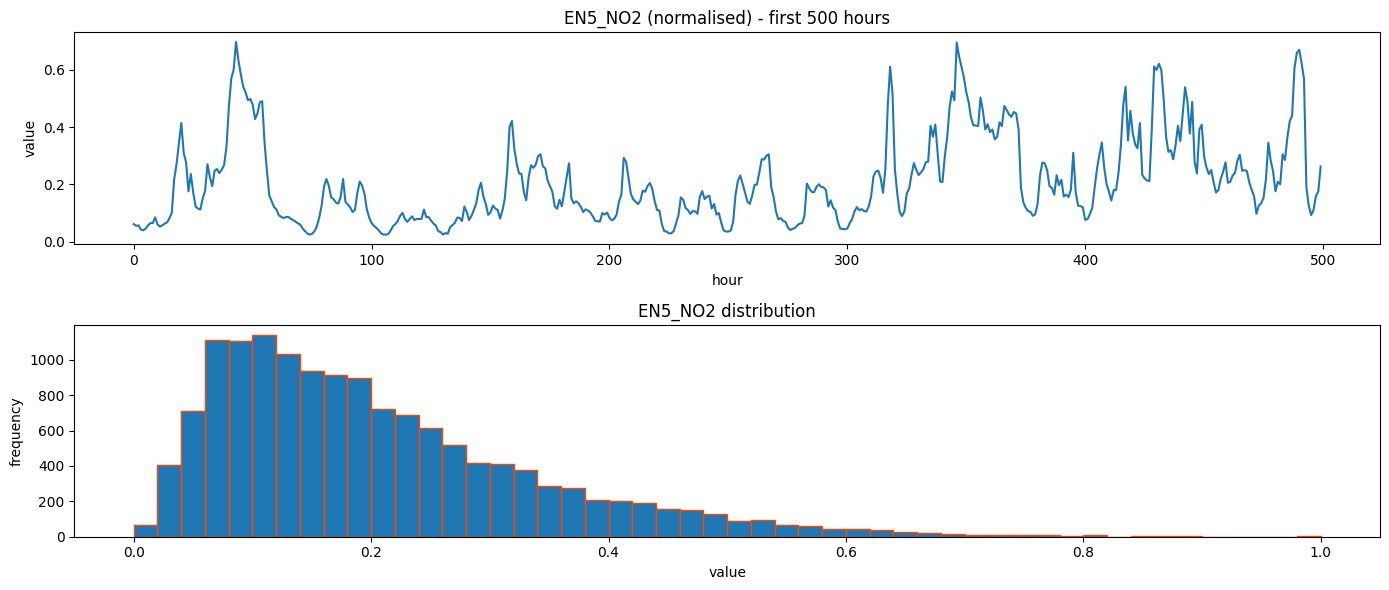

In [71]:
#Plot sample data.
#creates 2 plots stucked vertically size 14 and 6.
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# get a NO2 column 
no2_cols = [col for col in feature_names if 'NO2' in col]
#find all colm name no2 returns
if no2_cols:
    sample_col = no2_cols[0]
    
    # time series plot, gets indfex 0 to 500 hours
    axes[0].plot(df_normalised[sample_col].values[:500])
    axes[0].set_title(f'{sample_col} (normalised) - first 500 hours')
    axes[0].set_xlabel('hour')
    axes[0].set_ylabel('value')
    
    # labels for top plot, colur edgecolor='orangered'  because thats no2 concentration colour orange-brown
    axes[1].hist(df_normalised[sample_col].values, bins=50, edgecolor='orangered')


    axes[1].set_title(f'{sample_col} distribution')
    axes[1].set_xlabel('value')
    axes[1].set_ylabel('frequency')

#labels for bottom plot
plt.tight_layout()
#dpi = dots per inch adjustment for better quality
plt.savefig(visualisation_path/ 'data_overview.png', dpi=150)
plt.show()

##### What this visualisation tells me

Top plot shows NO2 at EN5 station for first 500 hours, roughly 21 days. Values goes between 0.05 and 0.7 with clear daily pattern repeating every 24 hours. Peaks are probably rush hours and dips are night time when less traffic.

Bottom plot shows how often each value appears across all data. Most values sit between 0.05 and 0.35, with peak around 0.1-0.15. Few high values near 1.0 which are pollution events.

Data looks correct. Normalisation worked, patterns are realistic for air pollution, ready for model training.

##### About the distribution shape

The frequency gets lower as value increases. This is normal for air pollution data.

**What it means:**

- Low NO2 values (0.0-0.2): happen most often, around 1000+ times each.
- Medium values (0.3-0.5): happen less, around 200-400 times.
- High values (0.6-1.0): rare, only few times.


**This is right-skewed distribution.** The tail extends to the right because extreme high values are rare but happens.

**Finally LAQN Gave me good sign for ML:**

The model will learn that low values are normal and high values are unusual. This is realistic behaviour for predicxtion.

I was expecting the distribution of LAQN would be flat or all values gathered at one point like Mount Everest, which would mean something was wrong.

### Complete:
- Starting the fun bit finally!
#### What are the things I should do?
- create new notebooks for ml training. 
1) rf_training.ipynb - training ml modelling for random forest. 
2) cnn_training,ipynb - training ml modelling for Convolutional neurol network.

- load this ml_prep folder arrays, to other notebook.
